### AMS 520 Kernel Learning Data

In [9]:
import numpy as np
import matplotlib.pyplot as plt
# ^^^ pyforest auto-imports - don't write above this line
import sys
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import collections
from itertools import chain
from matplotlib.dates import DateFormatter
path='/home/jbohn/jupyter/personal/sbu/Kernel_Learning'

sys.path.append(path)

# Data Set
- Trade and Quote Data for AAPL on NASDAQ between 01/01/2020 and 01/30/2020

### Preprocessing
- Removed trades outside of market hours and timestamp realignment


In [2]:
def clean_trades(trades):
    trades.index = pd.to_datetime(trades["Time"].values)
    

    trades["date"] = trades.index.date
    
    trades=trades[trades['Trade_Volume']>0]

    grouped_trades = trades.groupby("date").groups

    # drop trade data outside of market hours

    for day in grouped_trades.keys():
        subset = trades[trades["date"] == day]
        grouped_trades[day] = subset[
            subset.index < datetime.strptime(f"{day} 16:00:00", "%Y-%m-%d %H:%M:%S")
        ]
        grouped_trades[day] = subset[
            subset.index > datetime.strptime(f"{day} 09:30:00", "%Y-%m-%d %H:%M:%S")
        ]

    new_trades = pd.concat(list(grouped_trades.values())).sort_index()

    return new_trades


def clean_quotes(quotes, drop_after_hours=True):

    # parse date and pt
    quotes["date"] = quotes["Time"].apply(lambda x: str(x[:11]))
    quotes.index = quotes["date"] + quotes["Participant_Timestamp"].astype(str)
    quotes = quotes.drop(columns=["Participant_Timestamp", "date"])
    quotes = quotes.rename(
        columns={quotes.columns[0]: "Participant_Timestamp", "Time": "SIP_Timestamp"}
    )

    # convert pt to valid ts
    quotes.index = quotes.index.str[:-3]
    time = pd.Series(
        pd.to_datetime(quotes.index.str[11:].str.zfill(12), format="%H%M%S%f")
    )
    date = pd.Series(pd.to_datetime(quotes.index.str[:11]))
    quotes.index = date.apply(lambda x: x) + time.apply(
        lambda x: timedelta(
            hours=x.hour, minutes=x.minute, seconds=x.second, microseconds=x.microsecond
        )
    )

    quotes = quotes.sort_index()

    quotes = quotes.dropna(axis=1, how="all")

    quotes = quotes[
        quotes["Offer_Price"] > quotes["Bid_Price"]
    ]  # removed quotes with invalid spreads
    quotes = quotes[quotes["Bid_Price"] > 0]  # bid and offer price >0

    # drop after hours for quotes, preserve if want to prepend lob
    if drop_after_hours:
        quotes["date"] = quotes.index.date

        grouped_quotes = quotes.groupby("date").groups

        # drop trade data outside of market hours

        for day in grouped_quotes.keys():
            subset = quotes[quotes["date"] == day]
            grouped_quotes[day] = subset[
                subset.index < datetime.strptime(f"{day} 16:00:00", "%Y-%m-%d %H:%M:%S")
            ]
            grouped_quotes[day] = subset[
                subset.index > datetime.strptime(f"{day} 09:30:00", "%Y-%m-%d %H:%M:%S")
            ]
        new_quotes = pd.concat(list(grouped_quotes.values())).sort_index()

        return new_quotes
    else:
        return quotes

### Trade Features

TO:DO 
- Trade helpers for full db
- parsing for participant ts

In [3]:
trades=pd.read_csv(f"{path}/data/AAPL_trades.csv")
trades=clean_trades(trades)
trades.index=trades['Time']
trades=trades.drop(columns=trades.columns[:2])
trades.sort_index()

,Exchange,Symbol,Trade_Volume,Trade_Price,Sale_Condition,Source_of_Trade,date
Time,,,,,,,
2020-01-02 09:30:00.624116,N,AAPL,50,296.23,@ I,N,2020-01-02
2020-01-02 09:30:00.836409,N,AAPL,22,296.25,@ I,N,2020-01-02
2020-01-02 09:30:01.073828,N,AAPL,31,296.26,@ I,N,2020-01-02
2020-01-02 09:30:01.261512,N,AAPL,3,296.27,@ I,N,2020-01-02
2020-01-02 09:30:01.294279,N,AAPL,31,296.25,@ I,N,2020-01-02
...,...,...,...,...,...,...,...
2020-01-29 15:59:53.741022,N,AAPL,200,324.19,@,N,2020-01-29
2020-01-29 15:59:54.202375,N,AAPL,7,324.20,@F I,N,2020-01-29
2020-01-29 15:59:54.211587,N,AAPL,18,324.15,@F I,N,2020-01-29


In [4]:
sample_trades=trades[trades.index<"2020-01-03"]
sample_trades.index=pd.to_datetime(sample_trades.index)

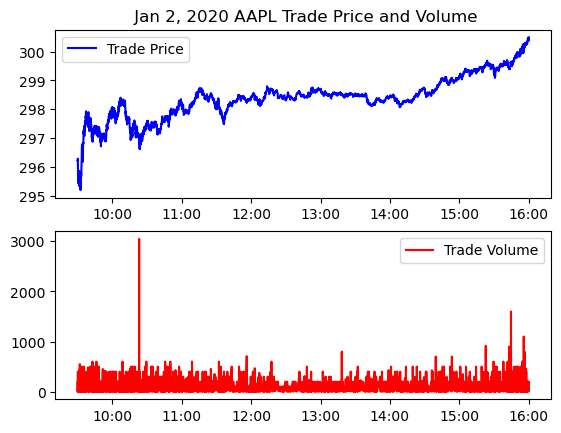

In [5]:
fig,ax=plt.subplots(2,1)
ax[0].plot(sample_trades["Trade_Price"],label='Trade Price',color='blue')
ax[1].plot(sample_trades["Trade_Volume"],label='Trade Volume',color='red')
ax[0].xaxis.set_major_formatter(DateFormatter("%H:%M"))
ax[1].xaxis.set_major_formatter(DateFormatter("%H:%M"))
ax[0].set_title(" Jan 2, 2020 AAPL Trade Price and Volume")
ax[0].legend()
ax[1].legend()

### Examine properties of Trades
    - @ : Regular Trade
    - @F : Regular Intermarket Sweep
    - @I : Regular Odd Lot
    - @IF: Regular Odd Lot Intermarket Sweep

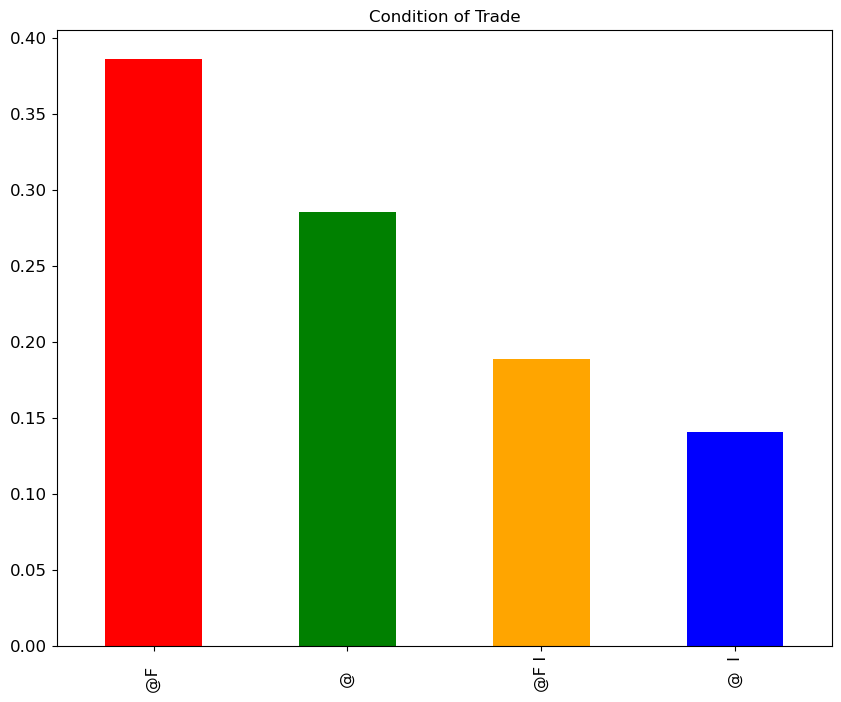

In [6]:
my_colors = c = ['red', 'green', 'orange', 'blue']
ax = (trades['Sale_Condition'].value_counts()/trades.shape[0]).plot(kind='bar', title ="Condition of Trade", figsize=(10,8),  fontsize=12,color=my_colors)

(array([6.7410e+03, 3.8380e+03, 5.4600e+03, 7.3990e+03, 1.2732e+04,
        6.9755e+04, 7.5770e+03, 4.0200e+02, 1.3000e+01, 3.0000e+00]),
 array([0.        , 0.90962754, 1.81925508, 2.72888262, 3.63851017,
        4.54813771, 5.45776525, 6.36739279, 7.27702033, 8.18664787,
        9.09627542]),
 <BarContainer object of 10 artists>)

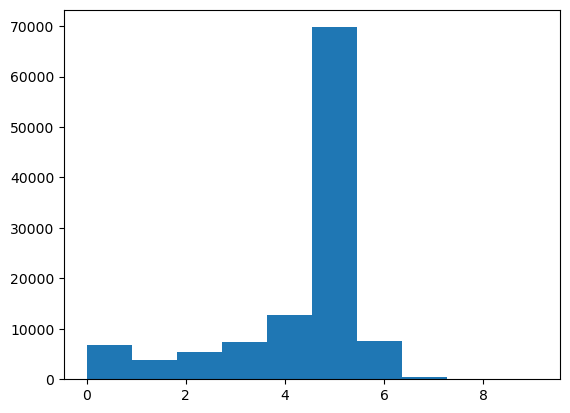

In [7]:
plt.hist(np.log(trades['Trade_Volume']))

### Quote Features

- CleanQuotes correctly aligned according to participant ts

In [15]:
quotes=pd.read_csv(f"{path}/data/AAPL_quotes.csv",nrows=10000)
quotes=clean_quotes(quotes)
quotes.to_csv('data/cleaned_quotes.csv')

In [16]:
quotes

,SIP_Timestamp,Exchange,Symbol,Bid_Price,Bid_Size,Offer_Price,Offer_Size,Quote_Condition,Sequence_Number,Source_Of_Quote,Best_Bid_Exchange,Best_Bid_Price,Best_Bid_Size,Best_Offer_Exchange,Best_Offer_Price,Best_Offer_Size,LULD_NBBO_Indicator,Security_Status_Indicator,date
2020-01-15 09:30:00.953633,2020-01-15 09:30:00.954013,N,AAPL,311.94,1.0,326.18,1.0,R,356546,N,N,311.94,1.0,V,311.96,1.0,A,,2020-01-15
2020-01-15 09:30:01.004096,2020-01-15 09:30:01.004476,N,AAPL,310.85,1.0,326.18,1.0,R,357650,N,Q,311.92,2.0,Q,311.99,1.0,A,,2020-01-15
2020-01-15 09:30:01.076382,2020-01-15 09:30:01.076759,N,AAPL,310.85,1.0,311.96,1.0,R,358817,N,Q,311.89,3.0,N,311.96,1.0,A,,2020-01-15
2020-01-15 09:30:01.645062,2020-01-15 09:30:01.645440,N,AAPL,310.85,1.0,311.95,4.0,R,363970,N,Q,311.90,1.0,N,311.95,4.0,A,,2020-01-15
2020-01-15 09:30:01.677976,2020-01-15 09:30:01.678357,N,AAPL,310.85,1.0,311.95,3.0,R,364328,N,P,311.86,2.0,N,311.95,3.0,A,,2020-01-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-15 09:59:50.747690,2020-01-15 09:59:50.748063,N,AAPL,315.37,3.0,315.43,1.0,R,3640538,N,Y,315.38,1.0,Z,315.43,6.0,A,,2020-01-15
2020-01-15 09:59:50.748211,2020-01-15 09:59:50.748585,N,AAPL,315.37,3.0,315.42,5.0,R,3640546,N,Y,315.38,1.0,N,315.42,5.0,A,,2020-01-15
2020-01-15 09:59:50.798011,2020-01-15 09:59:50.798384,N,AAPL,315.37,3.0,315.42,1.0,R,3640816,N,Y,315.38,1.0,N,315.42,1.0,A,,2020-01-15
2020-01-15 09:59:50.800193,2020-01-15 09:59:50.800566,N,AAPL,315.37,3.0,315.43,3.0,R,3640829,N,Z,315.39,2.0,Q,315.42,1.0,A,,2020-01-15


In [11]:
sample_quotes=quotes.copy()

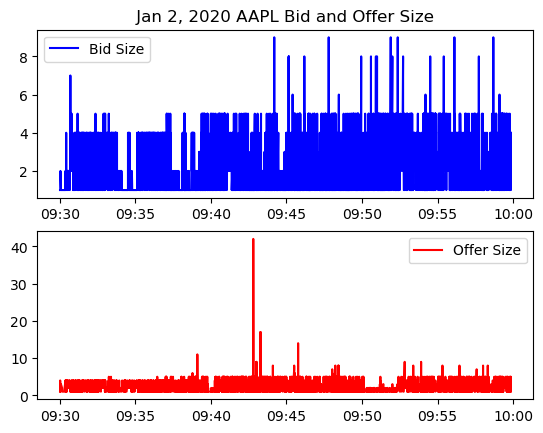

In [12]:
fig,ax=plt.subplots(2,1)
ax[0].plot(sample_quotes['Bid_Size'],label='Bid Size',color='blue')
ax[1].plot(sample_quotes['Offer_Size'],label='Offer Size',color='red')
ax[0].xaxis.set_major_formatter(DateFormatter("%H:%M"))
ax[1].xaxis.set_major_formatter(DateFormatter("%H:%M"))
ax[0].set_title(" Jan 2, 2020 AAPL Bid and Offer Size ")
ax[0].legend()
ax[1].legend()

In [13]:
bid_percent=(quotes['Bid_Price']<quotes['Best_Bid_Price']).sum()/len(quotes['Bid_Price'])
ask_percent=(quotes['Offer_Price']>quotes['Best_Offer_Price']).sum()/len(quotes['Offer_Price'])

print (bid_percent,ask_percent)

0.6172628617363344 0.6123392282958199


### Investigation into Latency